
# ICRA Tutorial 4, Contradictory Prior Data 2D

**API Version: JuliaLang Caesar.jl**

## Overview

- This example shows how prior (possibly contradictor) data can be incorporated into a localization and mapping solution.
- The value of having prior data for localization and mapping can be enormous, yet the risk of inducing unwanted errors due to contradictory data in the final problem are equally large -- this tutorial will show NavAbility's method of leveraging contradictory prior data as well as detecting discrepancies between "as-designed" and "as-built" artifacts.
- This tutorial will show how to use non-Gaussian inference to resolve the duality problem between measurement errors and contradictory data models by using the multi-hypothesis features in a factor graph solution.
- This tutorial is in 2D on a XY-plane, assuming a top down view.
- We assume a human operated surveyor measurement station is used for data collection to known markers in a construction environment.
- The data used to construct this tutorial is used to generate a factor graph which is solved and the results analyzed.
- The data is based on multiple measurement station locations to known makers in the environment.
- The measurement locations are not known in advance, but the relative translation between the measurement locations is known.
- The known marker locations are known only from the as-designed prior inforation -- for example a CAD model or floor plan of a construction.
- To simplify the tutorial, the measurements are assumed to be purely Gaussian and non-Guassian behavior is introduced only through the multi-hypothesis mechanism.
- This example shows one of four possible mechanisms by which non-Gaussian behavior can be introduced to a factor graph system.
- The multi-hypothesis mechanism used in this tutorial assumes the user will introduce discrete uncertainty into the estimation problem at the factor graph level.
  - This is difference from ICRA Tutorial 2 where discrete uncertainty about ambiguous data is marginalized into the measurement before a factor is created.
- Other mechanisms shown in other examples can readily be added to this tutorial for a more intricate system.

## Prior (Contradictory) Data

This tutorial will demonstrate through a simplified example how prior (contradictory) data can be leveraged in a localization and mapping solution using factor graphs.  We want to pre-load our robotic system with some basic information about the environment in which it will be operating so that it can more easily resolve it's position and navigate around.

### Room with a Door

Prior info:
- A rectangular room with the 4 corners as defining navigation affordances,
- A door which should* be hinged on the left side

## Import Packages

The first step load all the necessary packages, as listed in code blocks hereafter.  The following commented code block is only necessary if your environment does not have the necessary packages installed for whatever reason (uncomment and run once if package are not installed).

In [ ]:
# # install if necessary
# import Pkg; [Pkg.add(s) for s in ["RoME";"RoMEPlotting"; "GraphPlot"; "Logging"]];

For notebooks it's useful to reduce the amount of text printouts:

In [1]:
# suppress unnecessary printouts in the notebook
using Logging
Logging.disable_logging(Logging.Warn);


And then the actual solver and visualization packaged used in this tutorial:

In [2]:
using RoME
using GraphPlot
using RoMEPlotting

In [34]:
function plotRoom(fg)
  pl = plotSLAM2DLandmarks(fg, drawPoints=false, regexLandmark=r"c\d", drawContour=false, drawEllipse=true)
  pl2 = plotSLAM2DLandmarks(fg, drawPoints=false, regexLandmark=r"door_", drawContour=false, drawEllipse=true)
  union!(pl.layers, pl2.layers)
  pl.coord = Gadfly.Coord.Cartesian(xmin=-2,xmax=22,ymin=-2,ymax=12)
  pl
end

function plotTraj(fg, lbls=sortDFG(ls(fg, r"x\d")))
  pl = plotBelief(fg, lbls, dims=[1;2], c=RoMEPlotting.getColorsByLength(length(lbls)), levels=3)
  pl.coord = Gadfly.Coord.Cartesian(xmin=-2,xmax=22,ymin=-2,ymax=12)
  pl
end

function plotRoomTraj(fg)
  pl = plotTraj(fg)
  pl2 = plotRoom(fg)
  union!(pl.layers, pl2.layers)
  pl
end

plotRoomTraj (generic function with 1 method)

## Build a Multi-hypothesis Factor Graph

We start with an empty factor graph object, which is created with default solver parameters.

In [40]:
fg = initfg()

prior_distr= diagm([0.1, 0.1, 0.01].^2)
dual_distr= diagm([1, 1, sqrt(pi)].^2)

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  3.14159

Next, add to the factor graph the four corner prior knowledge about the room, namely `c0`, `c1`, `c2`, `c3`, each with their expected location in the world via `PriorPose2` unary factor:

In [41]:
addVariable!(fg, :c0, Pose2)
addFactor!(fg, [:c0], PriorPose2(MvNormal([0.,0, 0], prior_distr)))

addVariable!(fg, :c1, Pose2)
addFactor!(fg, [:c1], PriorPose2(MvNormal([20.,0, pi/2], prior_distr)))

addVariable!(fg, :c2, Pose2)
addFactor!(fg, [:c2], PriorPose2(MvNormal([20.,10, pi], prior_distr)))

addVariable!(fg, :c3, Pose2)
addFactor!(fg, [:c3], PriorPose2(MvNormal([0.,10, -pi/2], prior_distr)))

DFGFactor{CommonConvWrapper{PriorPose2...}}
  timestamp:     2022-04-24T11:30:49.729-07:00
   nstime:       0 nanoseconds
  label:         c3f1
  solvable:      1
  VariableOrder: [:c3]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: PriorPose2{FullNormal}
Z:
FullNormal(
dim: 3
μ: [0.0, 10.0, -1.5708]
Σ: [0.01 0.0 0.0; 0.0 0.01 0.0; 0.0 0.0 0.0001]
)



Also add the prior information regarding the door, and note for this simplified tutorial is using two affordance variables...

In [42]:
addVariable!(fg, :door_prior, Pose2)
addFactor!(fg, [:door_prior], PriorPose2(MvNormal([20.,4, 0], prior_distr)))

addVariable!(fg, :door_dual, Pose2)
addFactor!(fg, [:door_dual], PriorPose2(MvNormal([20.,4, pi], dual_distr)))

DFGFactor{CommonConvWrapper{PriorPose2...}}
  timestamp:     2022-04-24T11:30:52.305-07:00
   nstime:       0 nanoseconds
  label:         door_dualf1
  solvable:      1
  VariableOrder: [:door_dual]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: PriorPose2{FullNormal}
Z:
FullNormal(
dim: 3
μ: [20.0, 4.0, 3.14159]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 3.14159]
)



In [ ]:
solveGraph!(fg);

[0.008 -0.002; -0.002 0.009]
[0.009 0.003; 0.003 0.009]
[0.01 0.001; 0.001 0.01]
[0.009 0.0; 0.0 0.008]
[0.726 -0.039; -0.039 0.889]
[0.007 0.0; 0.0 0.009]


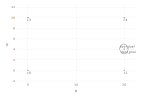

In [44]:
plotRoom(fg)

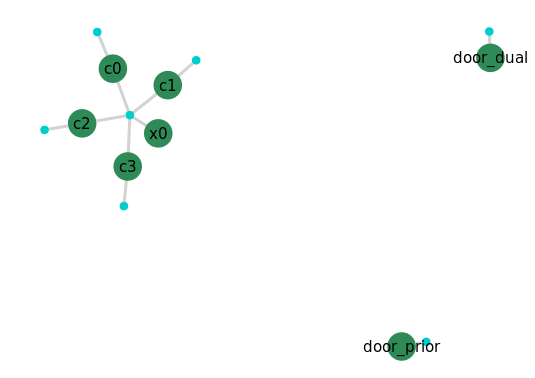

In [45]:
addVariable!(fg, :x0, Pose2)
addFactor!(
  fg, 
  [:x0, :c0, :c1, :c2, :c3], 
  Pose2Pose2(MvNormal([-2, -2, 0.], diagm([0.5, 0.5, 0.05].^2))), 
  multihypo=[1.0, 0.25, 0.25, 0.25, 0.25]
)

DFG.plotDFG(fg)

In [46]:
solveGraph!(fg)

Solve Progress: approx max 72, at iter 11 	 Time: 0:00:04Solve Progress: approx max 72, at iter 12 	 Time: 0:00:04Solve Progress: approx max 72, at iter 13 	 Time: 0:00:04

Solve Progress: approx max 72, at iter 33 	 Time: 0:00:04


Building Bayes net...
Find potential functions for each clique


MetaBayesTree
  Nr cliques:  3


[0.012 -0.0; -0.0 0.012]
[0.014 -0.001; -0.001 0.014]
[0.014 -0.0; -0.0 0.015]
[0.014 -0.002; -0.002 0.012]
[0.757 -0.037; -0.037 0.777]
[0.009 0.0; 0.0 0.01]


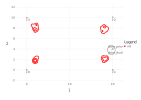

In [47]:
plotRoomTraj(fg)

In [48]:
addVariable!(fg, :x1, Pose2)
addFactor!(fg, [:x0, :x1], Pose2Pose2(MvNormal([4, 0, pi/2], diagm([0.5, 0.5, 0.05].^2))), nullhypo=0.5)

addFactor!(fg, [:x1, :c0, :c1, :c2, :c3], Pose2Pose2(MvNormal([-2, -4, 0], diagm([0.5, 0.5, 0.05].^2))), multihypo=[1.0, 0.25, 0.25, 0.25, 0.25])

DFGFactor{CommonConvWrapper{Pose2Pose2...}}
  timestamp:     2022-04-24T11:31:18.626-07:00
   nstime:       0 nanoseconds
  label:         x1c0c1c2c3f1
  solvable:      1
  VariableOrder: [:x1, :c0, :c1, :c2, :c3]
  multihypo:     [0.0, 0.25, 0.25, 0.25, 0.25]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: Pose2Pose2{FullNormal}
Z:
FullNormal(
dim: 3
μ: [-2.0, -4.0, 0.0]
Σ: [0.25 0.0 0.0; 0.0 0.25 0.0; 0.0 0.0 0.0025]
)



In [49]:
solveGraph!(fg)

Solve Progress: approx max 72, at iter 11 	 Time: 0:00:08Solve Progress: approx max 72, at iter 12 	 Time: 0:00:08Solve Progress: approx max 72, at iter 13 	 Time: 0:00:08

Solve Progress: approx max 72, at iter 23 	 Time: 0:00:09

Solve Progress: approx max 72, at iter 33 	 Time: 0:00:09


Building Bayes net...
Find potential functions for each clique


MetaBayesTree
  Nr cliques:  3


[0.008 0.003; 0.003 0.013]
[0.01 -0.002; -0.002 0.017]
[0.016 0.0; 0.0 0.015]
[0.012 -0.002; -0.002 0.011]
[1.112 -0.152; -0.152 1.316]
[0.012 -0.001; -0.001 0.011]


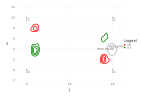

In [50]:
plotRoomTraj(fg)

In [51]:
addVariable!(fg, :x2, Pose2)
addFactor!(fg, [:x1, :x2], Pose2Pose2(MvNormal([16, 0, 0], diagm([0.5, 0.5, 0.05].^2))))

addFactor!(fg, [:x2, :c0, :c1, :c2, :c3], Pose2Pose2(MvNormal([2, -4, pi/2], diagm([0.5, 0.5, 0.05].^2))), multihypo=[1.0, 0.25, 0.25, 0.25, 0.25])

solveGraph!(fg)

Solve Progress: approx max 72, at iter 11 	 Time: 0:00:15Solve Progress: approx max 72, at iter 12 	 Time: 0:00:15Solve Progress: approx max 72, at iter 13 	 Time: 0:00:15

Solve Progress: approx max 72, at iter 23 	 Time: 0:00:15

Solve Progress: approx max 72, at iter 33 	 Time: 0:00:15


Building Bayes net...
Find potential functions for each clique


MetaBayesTree
  Nr cliques:  3


[0.012 0.001; 0.001 0.007]
[0.015 -0.001; -0.001 0.012]
[0.01 0.0; 0.0 0.008]
[0.009 -0.002; -0.002 0.011]
[1.041 0.005; 0.005 0.962]
[0.009 -0.0; -0.0 0.01]


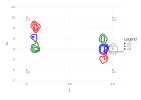

In [52]:
plotRoomTraj(fg)

In [ ]:
addFactor!(fg, [:x2, :door_prior, :door_dual], Pose2Pose2(MvNormal([2.0, 0, pi], diagm([0.5, 0.5, 0.05].^2))), multihypo=[1,0.5,0.5])

solveGraph!(fg)

[0.013 0.0; 0.0 0.013]
[0.011 0.001; 0.001 0.01]
[0.012 -0.001; -0.001 0.011]
[0.012 0.002; 0.002 0.009]
[0.728 -0.003; -0.003 0.793]
[0.009 0.003; 0.003 0.011]


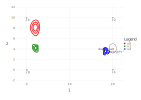

In [55]:
plotRoomTraj(fg)

## Resolved Door Orientation

The solver also resolved the correct `:door_` orientation from new measurement data.  We can see which door orientation was correct by looking at the PPEs of both the `prior` and `dual` versions:

In [59]:
function printHingedDoor(ornt, str="resolved")
  if abs(ornt) < pi/2
    println("Door affordance $str as left hinged")
  else
    println("Door affordance $str as right hinged")
  end
end

printHingedDoor(getPPE(fg, :door_prior).suggested[3],"prior")
printHingedDoor(getPPE(fg, :door_dual).suggested[3])

Door affordance prior as left hinged
Door affordance resolved as right hinged


This indicates that the door affordance **prior information is contradictory** but was correctly resolved during non-Gaussian inference in the factor graph to a stable, unimodal solution to the factor graph.  

Note that navigation affordances are a much deeper topic described in more detail in the paper linked below.  The door orientation example is a trivial case to help connnect the multi-hypothesis factors to navigation-affordances.

### Final Graph Structure

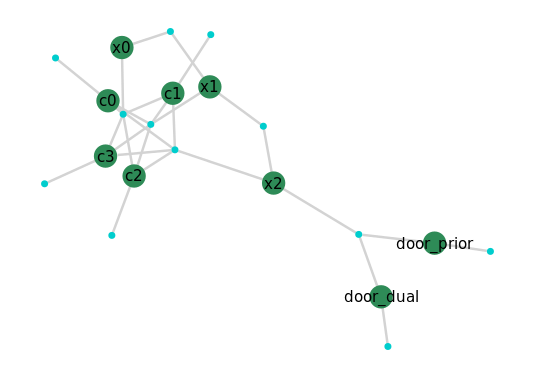

In [60]:
DFG.plotDFG(fg)

This concludes the tutorial on multi-hypothesis factors.

# Next Steps

## Navigation-Affordances

There is much more to say about navigation-affordances.

### As-Designed vs. As-Built

A dedicated [NavAbility Application Example](https://www.navability.io/applications/construction/) describes more details on navigation-affordances design patterns as well as a detailed IEEE RA-L paper description.